In [381]:
%load_ext autoreload
%autoreload 2
import json
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


use old data:
    Like reading players in athletic sports. Each person has their own style, first the model has to memorize, later it can be generalized.

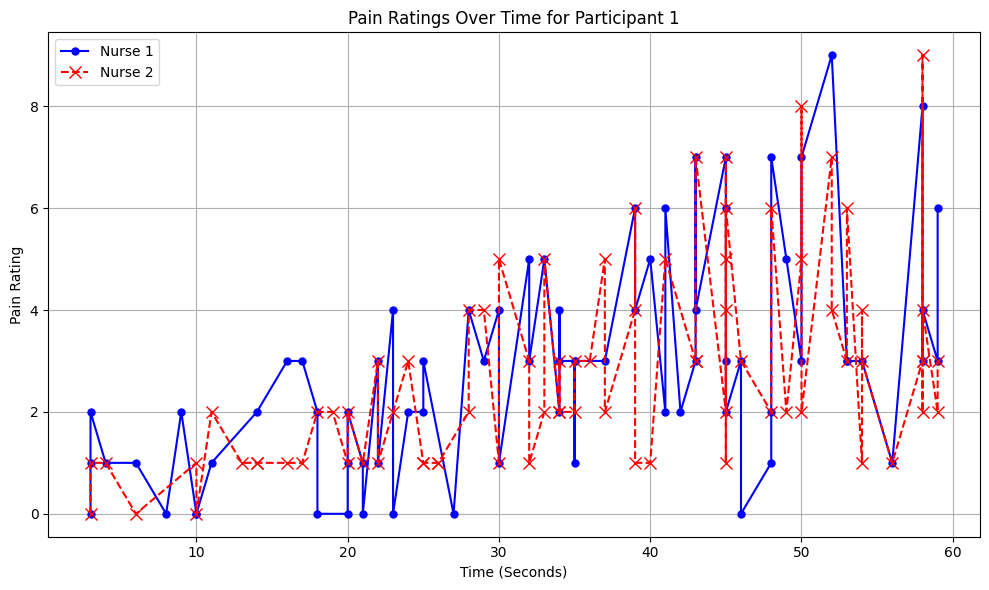

In [2]:
# Load the CSV file, handling duplicate column names and spaces
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split data into Nurse 1 and Nurse 2 sections
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Add a column to distinguish nurses
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'

# Combine both datasets
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)

# Filter for Participant 1 (convert to string for safety)
#combined['Participant'] = combined['Participant'].astype(str)
participant_1 = combined.copy()#[combined['Participant'].str.strip() == '1']

# Drop rows with missing time or pain data
participant_1 = participant_1.dropna(subset=['Pain'])

nurse1_data = participant_1[participant_1['Nurse'] == 'Nurse 1'].sort_values('Second')
nurse2_data = participant_1[participant_1['Nurse'] == 'Nurse 2'].sort_values('Second')

nurse1 = nurse1_data[nurse1_data['Second']<75]
nurse2 = nurse2_data[nurse2_data['Second']<75]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nurse1['Second'], nurse1['Pain'], 'b-o', label='Nurse 1', markersize=5)
plt.plot(nurse2['Second'], nurse2['Pain'], 'r--x', label='Nurse 2', markersize=8)
plt.xlabel('Time (Seconds)')
plt.ylabel('Pain Rating')
plt.title('Pain Ratings Over Time for Participant 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
participant_to_demonstrate = 6

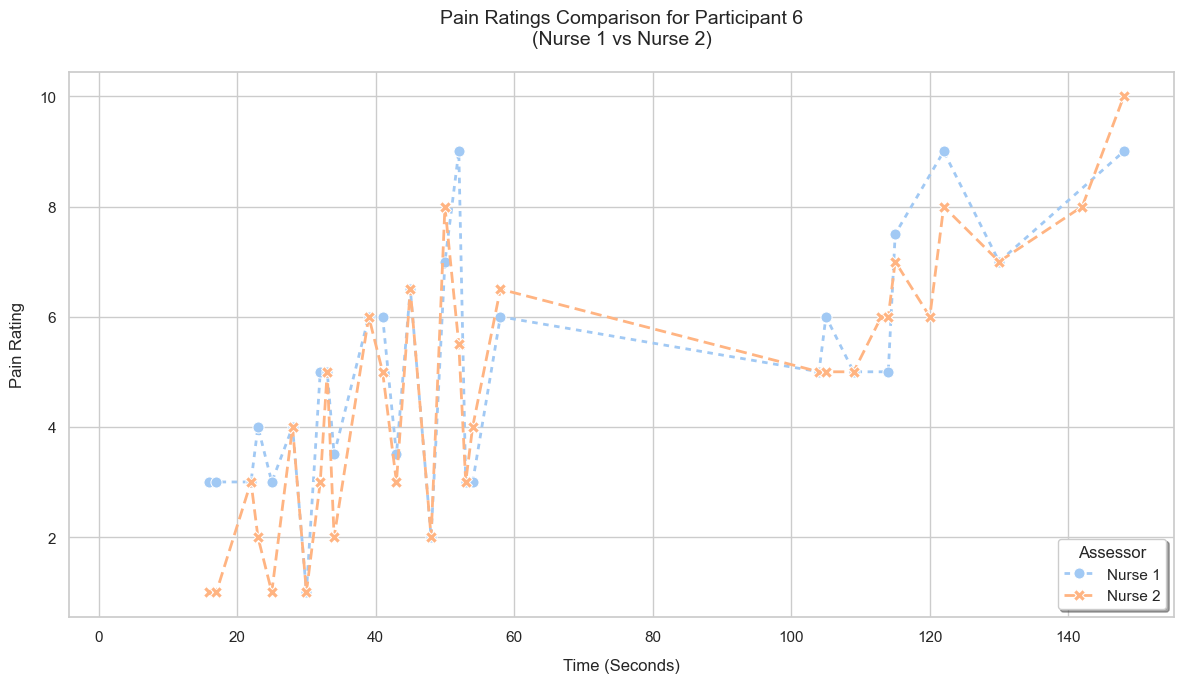

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)

# Clean data
combined = combined.dropna(subset=['Second', 'Pain'])
combined[['Second', 'Pain']] = combined[['Second', 'Pain']].apply(pd.to_numeric, errors='coerce')
combined = combined.dropna(subset=['Second', 'Pain'])

# Filter for Participant
p = participant_to_demonstrate

#participant_1 = combined[combined['Participant'].astype(str).str.strip() == p]
participant_data = combined[combined['Participant'] == p]

# Configure seaborn style
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

# Create line plot with enhanced visibility
sns.lineplot(
    data=participant_data,
    x='Second',
    y='Pain',
    hue='Nurse',
    style='Nurse',
    markers=True,
    dashes=[(2,2), (4,2)],
    markersize=8,
    linewidth=2,
    err_style=None,
)

# Add annotations and styling
plt.title(f'Pain Ratings Comparison for Participant {p}\n(Nurse 1 vs Nurse 2)', pad=20, fontsize=14)
plt.xlabel('Time (Seconds)', labelpad=10)
plt.ylabel('Pain Rating', labelpad=10)
plt.legend(title='Assessor', frameon=True, shadow=True)
plt.tight_layout()

# Add vertical lines for mode changes
for mode_time in participant_1.groupby('Mode')['Second'].min():
    plt.axvline(mode_time, color='gray', linestyle='--', alpha=0.0, lw=1)

plt.show()

In [411]:
# Save each participant's data to separate .csv files
# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain', 'Notes']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1', 'Notes.1']].copy()
# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain', 'Notes']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain', 'Notes']
# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()
    df_part['Mode'] = df_part['Mode'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)
# Clean data
combined = combined.dropna(subset=['Second', 'Pain'])
combined[['Second', 'Pain']] = combined[['Second', 'Pain']].apply(pd.to_numeric, errors='coerce')
combined = combined.dropna(subset=['Second', 'Pain'])

#combined.to_csv('forward_filled_nurse_scoring.csv')
#combined[combined['Participant']==5]


In [412]:
p=2

# 2. Ensure correct dtypes
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)
# 'Notes' stays as object (string)

# 3. Compute per-participant, per-mode offsets
offsets = {}
for pid, grp in combined.groupby('Participant'):
    mode_max = grp.groupby('Mode')['Second'].max().sort_index()
    cum = 0
    for mode, max_sec in mode_max.items():
        offsets[(pid, mode)] = cum
        cum += max_sec
        
# 4. Add cumulative seconds
combined['cum_second'] = combined.apply(lambda r: offsets[(r['Participant'], r['Mode'])] + r['Second'], axis=1)
#combined['cum_second'] -= combined.groupby('Participant')['cum_second'].transform('min')

combined[combined['Participant']==p]

,Participant,Mode,Second,Pain,Notes,Nurse,cum_second
16,2,1,10,0.0,normal,Nurse 1,10
17,2,1,25,2.0,low level speech /negative facial expresion,Nurse 1,25
18,2,1,50,3.0,moved hand / facial expresion,Nurse 1,50
19,2,1,110,3.0,moved hand / facial expresion,Nurse 1,110
20,2,1,117,5.0,expressed pain on shoulder,Nurse 1,117
21,2,1,152,7.0,moved hand / facial expresion/ asked to stop,Nurse 1,152
22,2,2,11,1.0,facial expresion,Nurse 1,163
23,2,2,24,2.0,facial expresion,Nurse 1,176
24,2,2,30,4.0,negative speech,Nurse 1,182
25,2,2,43,7.0,asked to stop,Nurse 1,195


In [413]:
# Load and preprocess data
combined = pd.read_csv('nurse_scoring/nurse_evaluation_forward_filled.csv')

# Convert columns to appropriate types
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)

# Step 1: Get max_second for each (Participant, Mode)
max_seconds = (
    combined.groupby(['Participant', 'Mode'])['Second']
    .max()
    .reset_index()
    .rename(columns={'Second': 'max_second'})
)

# Step 2: Generate full grid of all (Participant, Mode, Second) combinations
full_grid_list = []
for idx, row in max_seconds.iterrows():
    participant = row['Participant']
    mode = row['Mode']
    max_sec = row['max_second']
    seconds = np.arange(0, max_sec + 1)
    temp_df = pd.DataFrame({
        'Participant': participant,
        'Mode': mode,
        'Second': seconds
    })
    full_grid_list.append(temp_df)
full_grid = pd.concat(full_grid_list, ignore_index=True)

# Step 3: Pivot original data to wide format (Nurse columns)
wide = combined.pivot_table(
    index=['Participant', 'Mode', 'Second'],
    columns='Nurse',
    values=['Pain', 'Notes'],
    aggfunc='first'
)
wide.columns = [f"{val}_{nurse}" for val, nurse in wide.columns]
wide = wide.reset_index()

# Step 4: Merge full grid with pivoted data
merged = full_grid.merge(
    wide,
    on=['Participant', 'Mode', 'Second'],
    how='left'
)

# Step 5: Forward-fill missing values within each (Participant, Mode) group
merged.sort_values(['Participant', 'Mode', 'Second'], inplace=True)
fill_cols = ['Pain_Nurse 1', 'Pain_Nurse 2',]
merged[fill_cols] = merged.groupby(['Participant', 'Mode'])[fill_cols].ffill()

# Step 6: Fill remaining NaNs (e.g., no prior values to forward-fill)
merged.fillna({
    'Pain_Nurse 1': 0,
    'Pain_Nurse 2': 0,
    'Notes_Nurse 1': '',
    'Notes_Nurse 2': ''
}, inplace=True)

# Ensure integer types
merged[['Participant', 'Mode', 'Second']] = merged[['Participant', 'Mode', 'Second']].astype(int)

# Result
aligned_df = merged
aligned_df['Timestamp']=np.nan
aligned_df.query(f"Participant == {p}").to_csv(f'nurse_scoring/00{p}.csv')

In [414]:
# merge all self-report to one self-report .csv file
# load
p=2
self_df = pd.read_csv(f"self_report/00{p}.csv")
self_df['Participant'] = p
# floor timestamp to the scale of second
self_df['Timestamp'] = pd.to_datetime(self_df['Timestamp'], format="%Y-%m-%d %H:%M:%S.%f")
self_df['Timestamp_sec'] = self_df['Timestamp'].dt.floor('s')
# convert timestamps to relative time w.r.t. start of the session
self_df['cum_second'] = (
    self_df
    .groupby('Participant')['Timestamp_sec']
    .transform(lambda x: (x - x.min()).dt.total_seconds().astype(int))
)
self_df.to_csv(f'self_report/processed/00{p}.csv')
self_df

,Timestamp,PainLevel,Action,Participant,Timestamp_sec,cum_second
0,2025-03-12 10:01:45.587,NaN,Session Started,2,2025-03-12 10:01:45,0
1,2025-03-12 10:04:05.693,2.0,Selected,2,2025-03-12 10:04:05,140
2,2025-03-12 10:04:14.609,4.0,Selected,2,2025-03-12 10:04:14,149
3,2025-03-12 10:04:25.591,6.0,Selected,2,2025-03-12 10:04:25,160
4,2025-03-12 10:04:41.707,9.0,Selected,2,2025-03-12 10:04:41,176
5,2025-03-12 10:04:48.873,10.0,Selected,2,2025-03-12 10:04:48,183
6,2025-03-12 10:05:04.005,10.0,Selected,2,2025-03-12 10:05:04,199
7,2025-03-12 10:05:18.671,NaN,Finish Button Attempted,2,2025-03-12 10:05:18,213
8,2025-03-12 10:05:23.330,NaN,Finish Button Confirmed,2,2025-03-12 10:05:23,218
9,2025-03-12 10:05:23.330,NaN,Session Ended,2,2025-03-12 10:05:23,218


In [ ]:
# concat and align self report to the nurse evaluations
# load
p=7
self_df = pd.read_csv(f"self_report/00{p}.csv")
self_df['Participant'] = p
# floor timestamp to the scale of second
self_df['Timestamp'] = pd.to_datetime(self_df['Timestamp'], format="%Y-%m-%d %H:%M:%S.%f")
self_df['Timestamp_sec'] = self_df['Timestamp'].dt.floor('s')
# convert timestamps to relative time w.r.t. start of the session
self_df['cum_second'] = (
    self_df
    .groupby('Participant')['Timestamp_sec']
    .transform(lambda x: (x - x.min()).dt.total_seconds().astype(int))
)
#self_df['cum_second'] -= 104
# Assume columns: ['Elapsed', 'Pain_self'] or similar; rename Elapsed to cum_second
self_df = self_df.rename(columns={self_df.columns[1]:'Pain_SelfReport'})

self_df
aligned_df_1 = (
    aligned_df
      .query("Participant == 1")            # take only subject 1
      .merge(self_df[["cum_second","Pain_SelfReport"]],
             on="cum_second",
             how="left")
)
# forward fill
aligned_df_1['Pain_SelfReport']= aligned_df_1['Pain_SelfReport'].ffill().fillna(0)
aligned_df_1

In [ ]:
p=2
nurse_df = pd.read_csv(f"nurse_scoring/00{p}.csv") 
nurse_df["Timestamp"] = pd.to_datetime(nurse_df["Timestamp"])

# Extract mode start times and propagate within each mode
nurse_df["mode_start_time"] = nurse_df.groupby("Mode")["Timestamp"].transform("first")

# Calculate absolute timestamp for each evaluation
nurse_df["abs_time"] = nurse_df["mode_start_time"] + \
    pd.to_timedelta(nurse_df["Second"] - nurse_df.groupby("Mode")["Second"].transform('min'), unit="s")
nurse_df["abs_time_sec"] = nurse_df["abs_time"].dt.floor("s")

# Clean unnecessary columns
#nurse_df = nurse_df[["Participant", "Mode", "Second", "Pain_Nurse 1", "Pain_Nurse 2", "abs_time_sec"]]


#nurse_df.to_csv('test.csv')
#nurse_df[nurse_df['Mode']==2]

In [415]:
# Load nurse evaluations data
nurse_df = pd.read_csv(f"nurse_scoring/00{p}.csv")  # 
nurse_df["Timestamp"] = pd.to_datetime(nurse_df["Timestamp"])

# Extract mode start times and propagate within each mode
nurse_df["mode_start_time"] = nurse_df.groupby("Mode")["Timestamp"].transform("first")

# Calculate absolute timestamp for each evaluation
nurse_df["abs_time"] = nurse_df["mode_start_time"] + \
    pd.to_timedelta(nurse_df["Second"] - nurse_df.groupby("Mode")["Second"].transform('min'), unit="s")
nurse_df["abs_time_sec"] = nurse_df["abs_time"].dt.floor("s")

# Clean unnecessary columns
nurse_df = nurse_df[["Participant", "Mode", "Second", "Pain_Nurse 1", "Pain_Nurse 2", "Notes_Nurse 1", "Notes_Nurse 2", "abs_time_sec"]]

# Load self-report data
self_df = pd.read_csv(f"self_report/00{p}.csv")  # 
self_df["Timestamp"] = pd.to_datetime(self_df["Timestamp"])
self_df["Timestamp_sec"] = self_df["Timestamp"].dt.floor("s")

# Clean unnecessary columns
self_df = self_df[["Timestamp_sec", "PainLevel", "Action"]].rename(columns={'PainLevel': 'Pain_SelfReport'})
# Merge dataframes on aligned timestamps
merged_df = pd.merge(
    nurse_df,
    self_df,
    left_on="abs_time_sec",
    right_on="Timestamp_sec",
    how="outer"  # Use "left" or "right" to retain unmatched entries
)

# Sort by time
merged_df = merged_df.sort_values("abs_time_sec")
merged_df['Pain_SelfReport']=merged_df['Pain_SelfReport'].ffill().fillna(0)
# convert to absolute time
merged_df['Second']=(merged_df["abs_time_sec"].astype(int)-merged_df["abs_time_sec"][:1].astype(int).min())/1e9


merged_df.to_csv(f'merged_log/00{p}.csv')

merged_df

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action
1,2.0,1.0,0.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 10:03:34,NaT,0.0,NaN
2,2.0,1.0,1.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 10:03:35,NaT,0.0,NaN
3,2.0,1.0,2.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 10:03:36,NaT,0.0,NaN
4,2.0,1.0,3.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 10:03:37,NaT,0.0,NaN
5,2.0,1.0,4.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 10:03:38,NaT,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
155,NaN,NaN,7.481598e+09,NaN,NaN,NaN,NaN,NaT,2025-03-12 10:09:33,9.0,Session Started
156,NaN,NaN,7.481598e+09,NaN,NaN,NaN,NaN,NaT,2025-03-12 10:09:39,9.0,Finish Button Attempted
157,NaN,NaN,7.481598e+09,NaN,NaN,NaN,NaN,NaT,2025-03-12 10:09:44,9.0,Stop Button Pressed
158,NaN,NaN,7.481598e+09,NaN,NaN,NaN,NaN,NaT,2025-03-12 10:09:44,9.0,Suspended view appeared


In [378]:
pd.notna(merged_df)

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action
1,True,True,True,True,True,False,False,True,False,True,False
2,True,True,True,True,True,False,False,True,False,True,False
3,True,True,True,True,True,False,False,True,False,True,False
4,True,True,True,True,True,False,False,True,False,True,False
5,True,True,True,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
334,False,False,True,False,False,False,False,False,True,True,True
335,False,False,True,False,False,False,False,False,True,True,True
506,False,False,True,False,False,False,False,False,True,True,True
507,False,False,True,False,False,False,False,False,True,True,True


In [380]:
merged_df[pd.notna(merged_df['Notes_Nurse 2'])]

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action


<Figure size 1200x700 with 0 Axes>

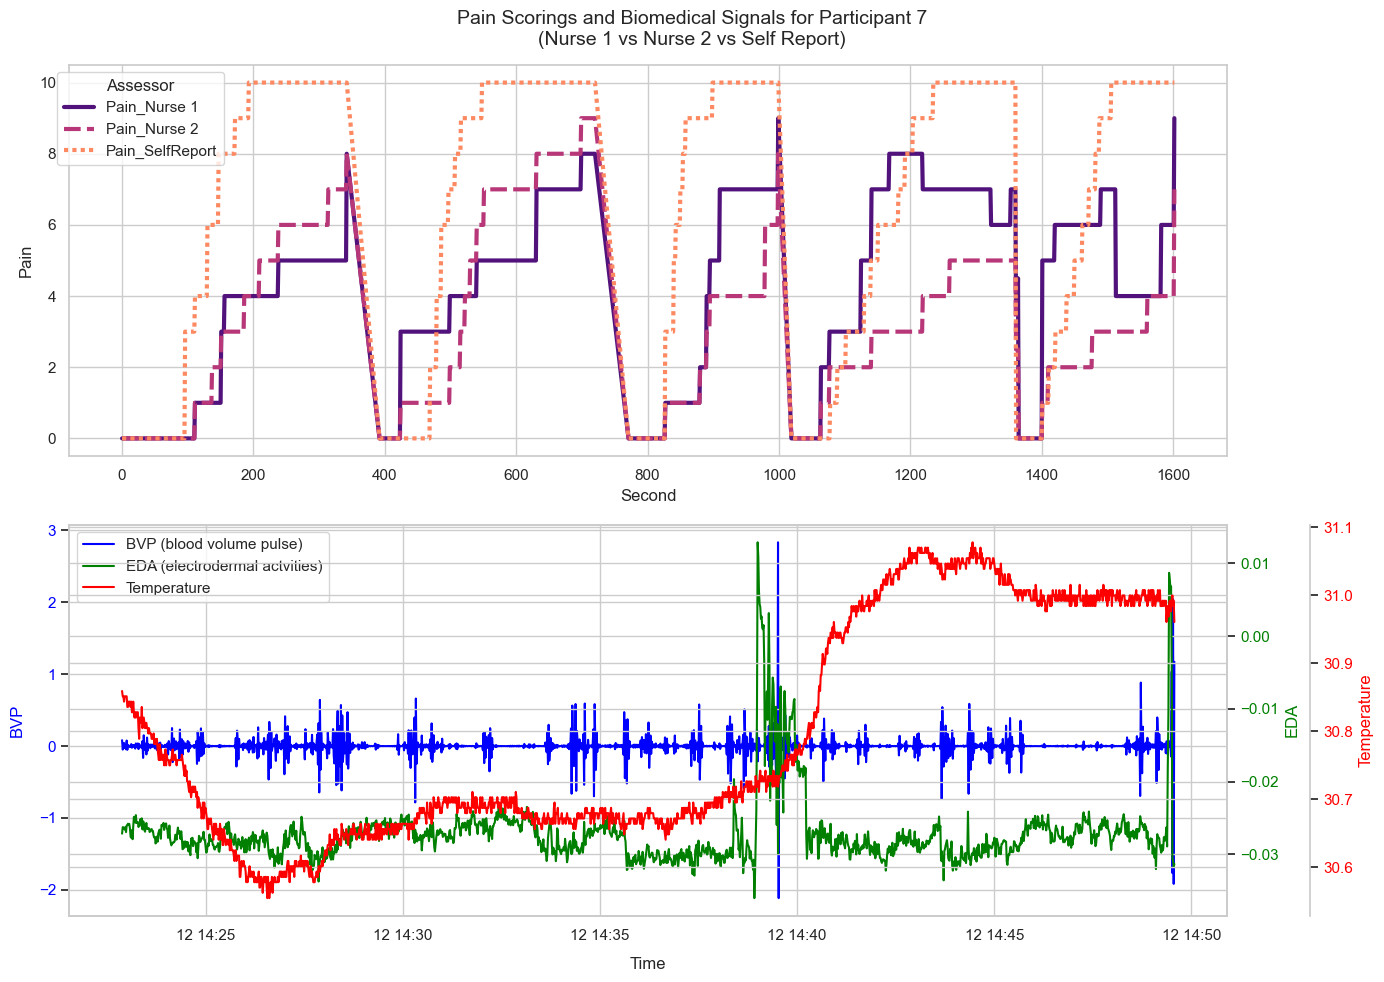

In [501]:
# Configure seaborn style
p=7
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

# get dataframes
merged_df = pd.read_csv(f'merged_log/00{p}.csv',index_col=0)
df = pd.read_csv(f'processed_signals/00{p+2}.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']*1e3)-np.timedelta64(4, 'h')
df.set_index('timestamp', inplace=True)
valid_dt = pd.to_datetime(merged_df['abs_time_sec'])
df = df[valid_dt.min():valid_dt.max()]

# ————————————————————————————————
# 2) Create a 2-row, shared-x figure
# ————————————————————————————————
sns.set_theme(style="whitegrid", palette="pastel")
fig, (ax_eval, ax_sig) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': [1, 1]}
)

# Create line plot with enhanced visibility
ax=sns.lineplot(
    data=merged_df.melt(id_vars=['Participant','Second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2', 'Pain_SelfReport'],
                        var_name='Nurse', value_name='Pain'),
    x='Second',
    y='Pain',
    hue='Nurse',
    style='Nurse',
    #markers=True,
    #dashes=[(2,2), (4,2)],
    markersize=8,
    linewidth=3,
    err_style=None,
    palette='magma',
    ax=ax_eval,
)

ax.legend(title='Assessor',loc='upper left',bbox_to_anchor=(-0.017, 1))

# Add annotations and styling
plt.suptitle(f'Pain Scorings and Biomedical Signals for Participant {p}\n(Nurse 1 vs Nurse 2 vs Self Report)', fontsize=14)
plt.xlabel('Time (Seconds)', labelpad=10)
plt.ylabel('Pain Rating', labelpad=10)
#plt.legend(title='Assessor', frameon=True, shadow=True)
plt.tight_layout()




df_resampled = df.resample('1s').mean().interpolate('time')  # or 'time', 'polynomial', etc.

# Plot the first signal
sns.lineplot(data=df_resampled, x=df_resampled.index, y='bvp', ax=ax_sig, label='BVP (blood volume pulse)', color='blue', legend=False)
ax_sig.set_ylabel('BVP', color='blue')
ax_sig.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax_sig.twinx()
sns.lineplot(data=df_resampled, x=df_resampled.index, y='eda', ax=ax2, label='EDA (electrodermal actvities)', color='green', legend=False)
ax2.set_ylabel('EDA', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax_sig.twinx()

# Offset the third axis to the right
ax3.spines['right'].set_position(('outward', 60))
sns.lineplot(data=df_resampled, x=df_resampled.index, y='temperature', ax=ax3, label='Temperature', color='red', legend=False)
ax3.set_ylabel('Temperature', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Set the x-axis label and title
ax_sig.set_xlabel('Time')
#plt.title(f'BVP, EDA, and Temperature Over Time of Participant {p} with Multiple Y-Axes')

# Combine legends from all axes
lines_1, labels_1 = ax_sig.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax_sig.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()


plt.show()

<Figure size 1200x700 with 0 Axes>

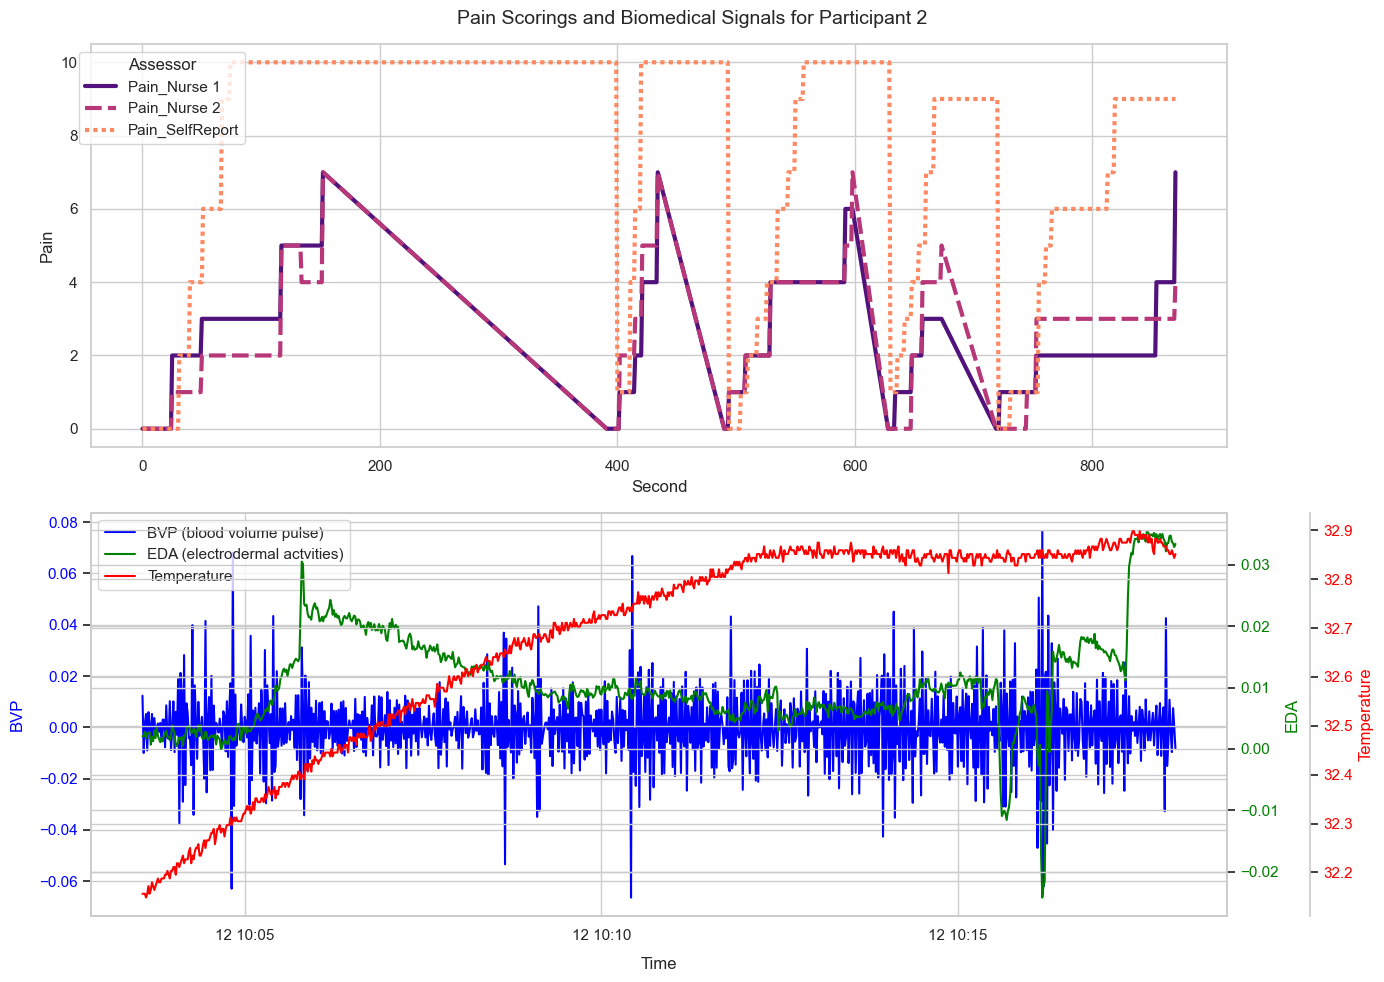

In [508]:
# Configure seaborn style
p=2
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

# get dataframes
merged_df = pd.read_csv(f'merged_log/00{p}.csv',index_col=0)
df = pd.read_csv(f'processed_signals/00{p+2}.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']*1e3)-np.timedelta64(4, 'h')
df.set_index('timestamp', inplace=True)
valid_dt = pd.to_datetime(merged_df['abs_time_sec'])
df = df[valid_dt.min():valid_dt.max()]

# ————————————————————————————————
# 2) Create a 2-row, shared-x figure
# ————————————————————————————————
sns.set_theme(style="whitegrid", palette="pastel")
fig, (ax_eval, ax_sig) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': [1, 1]}
)

# Create line plot with enhanced visibility
ax=sns.lineplot(
    data=merged_df.melt(id_vars=['Participant','Second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2', 'Pain_SelfReport'],
                        var_name='Nurse', value_name='Pain'),
    x='Second',
    y='Pain',
    hue='Nurse',
    style='Nurse',
    #markers=True,
    #dashes=[(2,2), (4,2)],
    markersize=8,
    linewidth=3,
    err_style=None,
    palette='magma',
    ax=ax_eval,
)

ax.legend(title='Assessor',loc='upper left',bbox_to_anchor=(-0.017, 1))

# Add annotations and styling
plt.suptitle(f'Pain Scorings and Biomedical Signals for Participant {p}', fontsize=14)
plt.xlabel('Time (Seconds)', labelpad=10)
plt.ylabel('Pain Rating', labelpad=10)
#plt.legend(title='Assessor', frameon=True, shadow=True)
plt.tight_layout()




df_resampled = df.resample('1s').mean().interpolate('time')  # or 'time', 'polynomial', etc.

# Plot the first signal
sns.lineplot(data=df_resampled, x=df_resampled.index, y='bvp', ax=ax_sig, label='BVP (blood volume pulse)', color='blue', legend=False)
ax_sig.set_ylabel('BVP', color='blue')
ax_sig.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax_sig.twinx()
sns.lineplot(data=df_resampled, x=df_resampled.index, y='eda', ax=ax2, label='EDA (electrodermal actvities)', color='green', legend=False)
ax2.set_ylabel('EDA', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax_sig.twinx()

# Offset the third axis to the right
ax3.spines['right'].set_position(('outward', 60))
sns.lineplot(data=df_resampled, x=df_resampled.index, y='temperature', ax=ax3, label='Temperature', color='red', legend=False)
ax3.set_ylabel('Temperature', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Set the x-axis label and title
ax_sig.set_xlabel('Time')
#plt.title(f'BVP, EDA, and Temperature Over Time of Participant {p} with Multiple Y-Axes')

# Combine legends from all axes
lines_1, labels_1 = ax_sig.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax_sig.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()


plt.show()

In [257]:
# on all ratings
from pingouin import intraclass_corr
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
import krippendorff
#
metrics_by_participant = pd.DataFrame()
#
for p in range(7,8):
    #p=1
    paired = aligned_df_1[aligned_df_1['Participant']==p]
    data = [
        paired['Pain_Nurse 1'].dropna().tolist(), 
        paired['Pain_Nurse 2'].dropna().tolist(),
        paired['Pain_SelfReport'].dropna().tolist(),
    ]
    # melt back to long form if needed
    long = aligned_df_1.melt(id_vars=['Participant','cum_second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2', 'Pain_SelfReport'],
                        var_name='Nurse', value_name='Pain')

    """ icc = intraclass_corr(data=long,
                        targets='Participant',
                        raters='Nurse',
                        ratings='Pain',
                        nan_policy='omit'
                        ) """

    metrics = {
        'Participant': str(p),
        'Cohen’s κ': cohen_kappa_score( paired['Pain_Nurse 2'],paired['Pain_SelfReport']),
        'Weighted κ-1': cohen_kappa_score( paired['Pain_Nurse 2'], paired['Pain_SelfReport'], weights='linear'),
        'Weighted κ-2': cohen_kappa_score( paired['Pain_Nurse 2'], paired['Pain_SelfReport'], weights='quadratic'),
        'MAE': mean_absolute_error( paired['Pain_Nurse 2'], paired['Pain_SelfReport']),
        'Exact Agreement (%)': (paired['Pain_Nurse 2'] == paired['Pain_SelfReport']).mean() * 100,
        'Krippendorff\'s Alpha': krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal'),
        #'CCC': concordance_correlation(paired['Nurse1'], paired['Nurse2']).squeeze(),
    }
    metrics_by_participant = pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)


metrics
#metrics_by_participant['Exact Agreement (%)'] = metrics_by_participant['Exact Agreement (%)']/100
metrics_by_participant

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,7,0.020533,0.408074,0.624192,2.610022,5.664488,0.566203


In [82]:
from pingouin import intraclass_corr
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
import krippendorff
#
metrics_by_participant = pd.DataFrame()
#
for p in range(1,8):
    #p=1
    paired = aligned_df[aligned_df['Participant']==p]
    data = [
        paired['Pain_Nurse 1'].dropna().tolist(), 
        paired['Pain_Nurse 2'].dropna().tolist()
    ]
    # melt back to long form if needed
    long = aligned_df.melt(id_vars=['Participant','cum_second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2'],
                        var_name='Nurse', value_name='Pain')

    icc = intraclass_corr(data=long,
                        targets='Participant',
                        raters='Nurse',
                        ratings='Pain',
                        )

    metrics = {
        'Participant': str(p),
        'Cohen’s κ': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2']),
        'Weighted κ-1': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2'], weights='linear'),
        'Weighted κ-2': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2'], weights='quadratic'),
        'MAE': mean_absolute_error(paired['Pain_Nurse 1'], paired['Pain_Nurse 2']),
        'Exact Agreement (%)': (paired['Pain_Nurse 1'] == paired['Pain_Nurse 2']).mean() * 100,
        'Krippendorff\'s Alpha': krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal'),
        #'CCC': concordance_correlation(paired['Nurse1'], paired['Nurse2']).squeeze(),
    }
    metrics_by_participant = pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)

icc
metrics
metrics_by_participant['Exact Agreement (%)'] = metrics_by_participant['Exact Agreement (%)']/100
metrics_by_participant

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,1,0.023484,0.218533,0.317488,1.784219,0.093398,0.289799
1,2,0.18342,0.614177,0.862037,0.679592,0.330612,0.81361
2,3,-0.0198,-0.043989,-0.074065,2.560909,0.067273,-0.143597
3,4,0.278413,0.168814,0.101897,1.034025,0.459751,0.314537
4,5,0.339188,0.36181,0.277937,1.330446,0.438119,0.289518
5,6,0.208728,0.699655,0.910183,0.796137,0.309013,0.843806
6,7,0.021504,0.355567,0.569316,1.790393,0.129549,0.533881


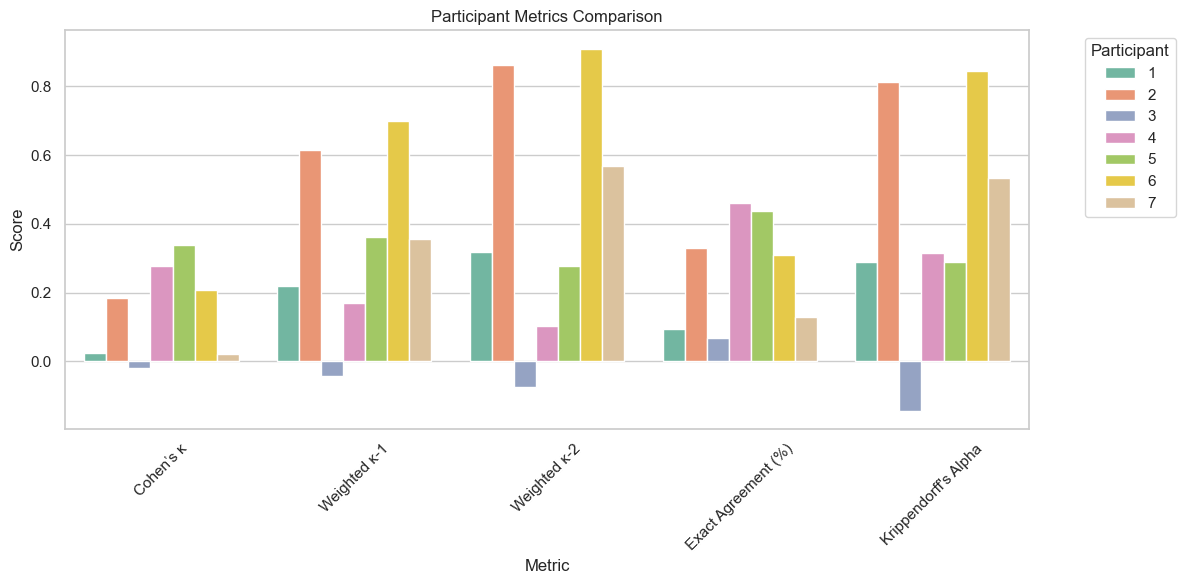

In [84]:
import seaborn as sns

df_long = metrics_by_participant.drop(['MAE'], axis=1).melt(id_vars='Participant', 
                  var_name='Metric', 
                  value_name='Score')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(data=df_long, 
            x='Metric', 
            y='Score', 
            hue='Participant', 
            palette='Set2')

plt.title("Participant Metrics Comparison")
plt.xticks(rotation=45)
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#sns.barplot(metrics_by_participant, y='Cohen’s κ', x='Participant',)

In [65]:
metrics_by_participant = pd.DataFrame()
#metrics_by_participant = pd.DataFrame(pd.Series(metrics)).transpose()
pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,1,0.023484,0.218533,0.317488,1.784219,9.339775,0.498014


In [105]:
# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
nurse1_df

,Participant,Mode,Second,Pain,Nurse
0,1.0,1.0,314.0,4.0,Nurse 1
1,1.0,NaN,341.0,4.0,Nurse 1
2,1.0,NaN,405.0,7.0,Nurse 1
3,1.0,2.0,21.0,1.0,Nurse 1
4,1.0,NaN,48.0,7.0,Nurse 1
...,...,...,...,...,...
178,7.0,NaN,NaN,NaN,Nurse 1
179,7.0,NaN,NaN,NaN,Nurse 1
180,7.0,NaN,NaN,NaN,Nurse 1
181,7.0,NaN,NaN,NaN,Nurse 1


In [110]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
from tabulate import tabulate

# Load data and clean
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Extract paired observations (same-row comparisons)
paired = df[['Pain', 'Pain.1']].dropna()
paired.columns = ['Nurse1', 'Nurse2']

In [111]:
#paired=combined
# Calculate metrics
metrics = {
    #'Concordance Correlation (CCC)': pg.concordance_correlation(paired['Nurse1'], paired['Nurse2']).loc['ccc', 'CCC'],
    #'Intra-class Correlation (CCC)': pg.intraclass_corr(paired['Nurse1'], paired['Nurse2'])#.loc['ccc', 'CCC'],
    'Pearson r': stats.pearsonr(paired['Nurse1'], paired['Nurse2'])[0],
    'Spearman rho': stats.spearmanr(paired['Nurse1'], paired['Nurse2'])[0],
    'Mean Absolute Error (MAE)': np.mean(np.abs(paired['Nurse1'] - paired['Nurse2'])),
    'Root Mean Squared Error (RMSE)': np.sqrt(np.mean((paired['Nurse1'] - paired['Nurse2'])**2)),
    'Exact Agreement (%)': np.mean(paired['Nurse1'] == paired['Nurse2']) * 100,
    'Mean Difference (Bland-Altman)': np.mean(paired['Nurse1'] - paired['Nurse2']),
    'Limits of Agreement (±1.96SD)': 1.96*np.std(paired['Nurse1'] - paired['Nurse2'], ddof=1)
}

# Create formatted table
table_data = [[k, f"{v:.3f}" if isinstance(v, float) else f"±{v:.3f}"] 
              for k, v in metrics.items()]

print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='pretty'))

+--------------------------------+--------+
|             Metric             | Value  |
+--------------------------------+--------+
|           Pearson r            | 0.060  |
|          Spearman rho          | 0.043  |
|   Mean Absolute Error (MAE)    | 2.643  |
| Root Mean Squared Error (RMSE) | 3.189  |
|      Exact Agreement (%)       | 10.714 |
| Mean Difference (Bland-Altman) | 0.179  |
| Limits of Agreement (±1.96SD)  | 6.258  |
+--------------------------------+--------+


In [96]:
pg.intraclass_corr(paired[['Nurse1']], paired[['Nurse2']])

AssertionError: 

In [98]:
paired[['Nurse1']]

,Nurse1
0,4.0
1,4.0
2,7.0
3,1.0
4,7.0
...,...
169,4.0
170,4.0
171,4.0
172,6.0


In [ ]:
# align nurse evaluations
import pandas as pd
import numpy as np

# 2. Ensure correct dtypes
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)
# 'Notes' stays as object (string)

# 3. Compute per-participant, per-mode offsets
offsets = {}
for pid, grp in combined.groupby('Participant'):
    mode_max = grp.groupby('Mode')['Second'].max().sort_index()
    cum = 0
    for mode, max_sec in mode_max.items():
        offsets[(pid, mode)] = cum
        cum += max_sec

# 4. Add cumulative seconds
combined['cum_second'] = combined.apply(lambda r: offsets[(r['Participant'], r['Mode'])] + r['Second'], axis=1)
combined['cum_second'] -= combined.groupby('Participant')['cum_second'].transform('min')

# 5. Pivot to wide, keeping Pain and Notes
wide = combined.pivot_table(
    index=['Participant', 'cum_second', 'Mode'],
    columns='Nurse',
    values=['Pain', 'Notes'],
    aggfunc='first'
)
# Flatten column index
wide.columns = [f"{val}_{nurse}" for val, nurse in wide.columns]
wide = wide.reset_index()

# 6. Build full timeline per participant, merge, then fill forward Mode
aligned_list = []
for pid, grp in wide.groupby('Participant'):
    max_t = grp['cum_second'].max()
    full = pd.DataFrame({
        'Participant': pid,
        'cum_second': np.arange(0, max_t + 1)
    })
    merged = full.merge(grp, on=['Participant', 'cum_second'], how='outer')
    # forward/back-fill Mode for seconds without direct observations
    merged['Mode'] = merged['Mode'].ffill().bfill()
    aligned_list.append(merged)

aligned_df = pd.concat(aligned_list, ignore_index=True)
# forward fill ratings
aligned_df['Pain_Nurse 1'] = pd.DataFrame(aligned_df.groupby(['Participant', 'Mode'])['Pain_Nurse 1'].ffill())
aligned_df['Pain_Nurse 2'] = pd.DataFrame(aligned_df.groupby(['Participant', 'Mode'])['Pain_Nurse 2'].ffill())
#aligned_df['Pain_Nurse 1'] = aligned_df['Pain_Nurse 1'].ffill()
#aligned_df['Pain_Nurse 2'] = aligned_df['Pain_Nurse 2'].ffill()

aligned_df = aligned_df.fillna({'Pain_Nurse 1':0, 'Pain_Nurse 2':0})
#aligned_df.to_csv('nurse_evaluation_aligned_ff.csv')
#aligned_df = aligned_df.iloc[276:]

aligned_df['Timestamp']=np.nan

p=6
aligned_df.query(f"Participant == {p}").to_csv(f'nurse_scoring/00{p}.csv')